<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/ecoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install packages**

In [1]:
# Install packages
!pip install pyforest
!pip install pca

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=9ce5f1290b288fdee671e135b7937f5659781f6afc24634b59c203bdabe77ef8
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.7 MB/s eta 0:00:00


#**Load dataset**

In [2]:
# Import necessary libraries
from pyforest import*
lazy_imports() # load most libraries
from pca import pca
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report # evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve # plots

In [3]:
# Load dataset
url = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Ecoli_eng.csv'
data = pd.read_csv(url)
X = data.loc[:, ~data.columns.isin(['id', 'smiles', 'Ecoli'])]
y = data.iloc[:, 2].values
cols = data.columns
print(X.shape)
X.head()

<IPython.core.display.Javascript object>

(2268, 2048)


ECFP0  ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  ...  \
0      0      1      0      0      0      1      0      0      1      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      1      0      0      0      0      0      0      1      0  ...   
3      0      1      0      0      0      0      0      0      0      0  ...   
4      0      1      0      0      0      0      0      0      0      0  ...   

   ECFP2038  ECFP2039  ECFP2040  ECFP2041  ECFP2042  ECFP2043  ECFP2044  \
0         0         0         0         0         0         0         0   
1         0         0         0         1         1         0         0   
2         0         0         0         0         0         0         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         1         0         0   

   ECFP2045  ECFP2046  ECFP2047  
0         0         0         0  
1         0         0         0  
2         1         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 2048 columns]

In [4]:
# Check missing or null values
print(f'There are {pd.concat([data], axis=1).isnull().sum().sum()} missing values \n')

# Count target
print(f'Count of non-AEP: {data["Ecoli"].value_counts()[0]}')
print(f'Count of AEP: {data["Ecoli"].value_counts()[1]}')

<IPython.core.display.Javascript object>

There are 0 missing values 

Count of non-AEP: 913
Count of AEP: 1355


#**PCA**

In [5]:
# Initialize pca
model=pca(n_components=0.95, normalize=True)

# Fit transform
results = model.fit_transform(X)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2048] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [779] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2048] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[779]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


<IPython.core.display.Javascript object>

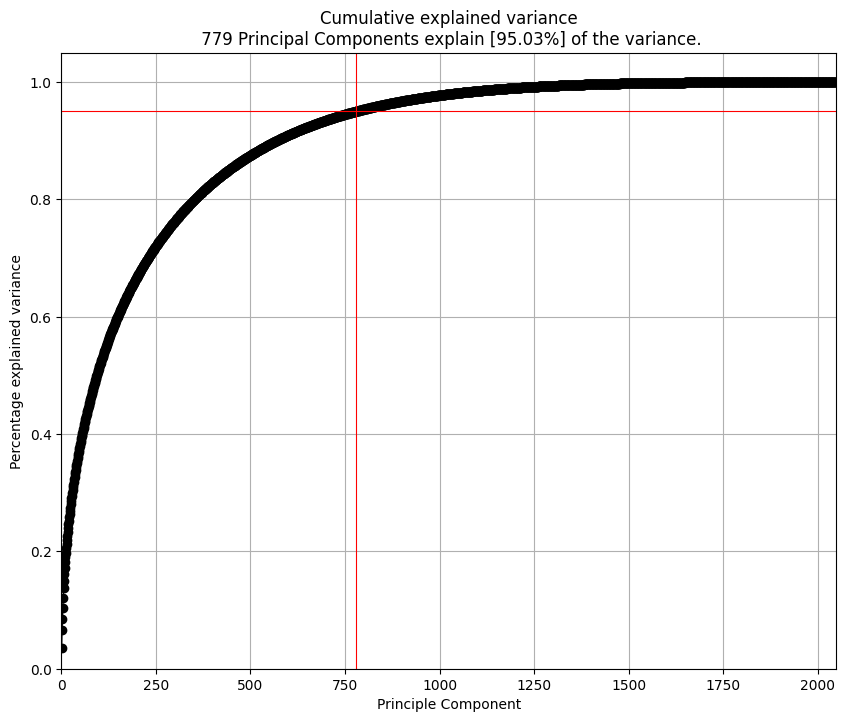

In [6]:
# Screen plot
model.plot(figsize=(10,8))
plt.show()

In [7]:
# Print top features
top = model.results['topfeat']
best = top.loc[top['type']=='best']
best

PC   feature   loading  type
0      PC1  ECFP1034  0.094837  best
1      PC2   ECFP680 -0.077032  best
2      PC3  ECFP1123  0.104535  best
3      PC4   ECFP714  0.111075  best
4      PC5  ECFP1910  0.083125  best
..     ...       ...       ...   ...
774  PC775  ECFP1429 -0.082382  best
775  PC776  ECFP1191  0.080761  best
776  PC777   ECFP878 -0.084305  best
777  PC778  ECFP1852 -0.087214  best
778  PC779  ECFP1991 -0.080506  best

[779 rows x 4 columns]

[scatterd] >INFO> Create scatterplot


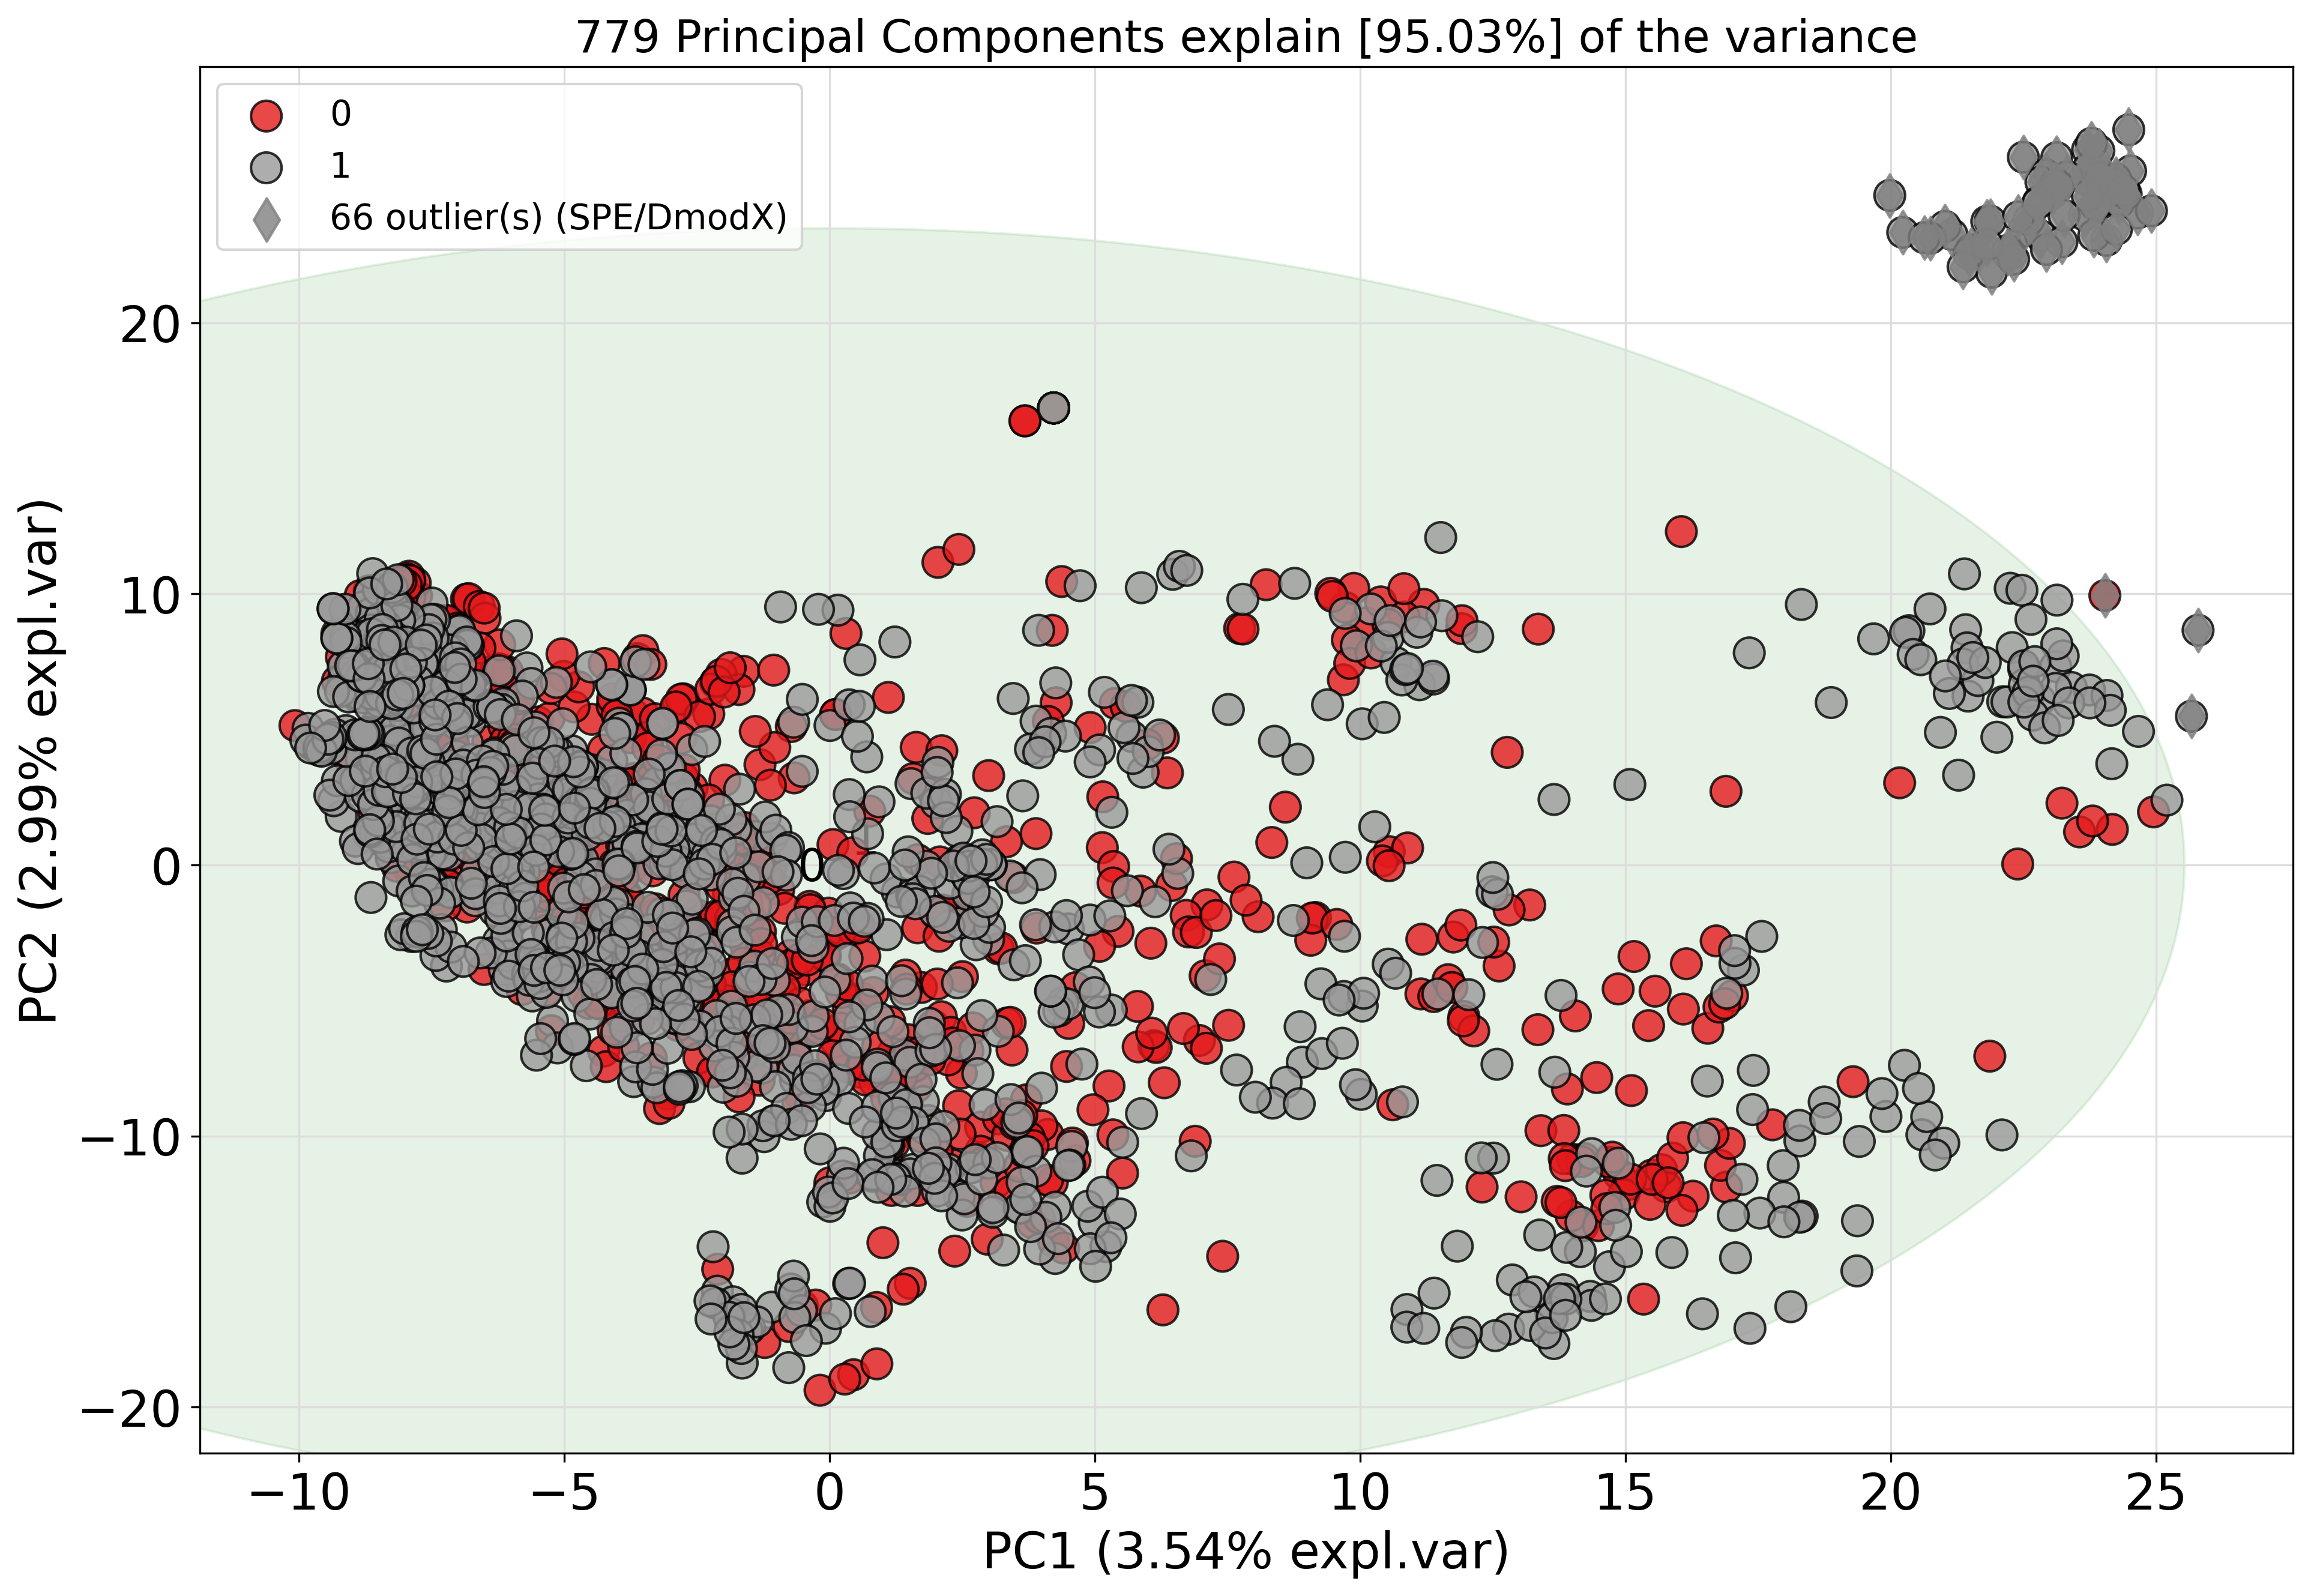

In [8]:
# 2D scatter plot
model.scatter(labels=y, SPE=True, legend=True, cmap='Set1', figsize=(15,10), dpi=300);

[scatterd] >INFO> Create scatterplot


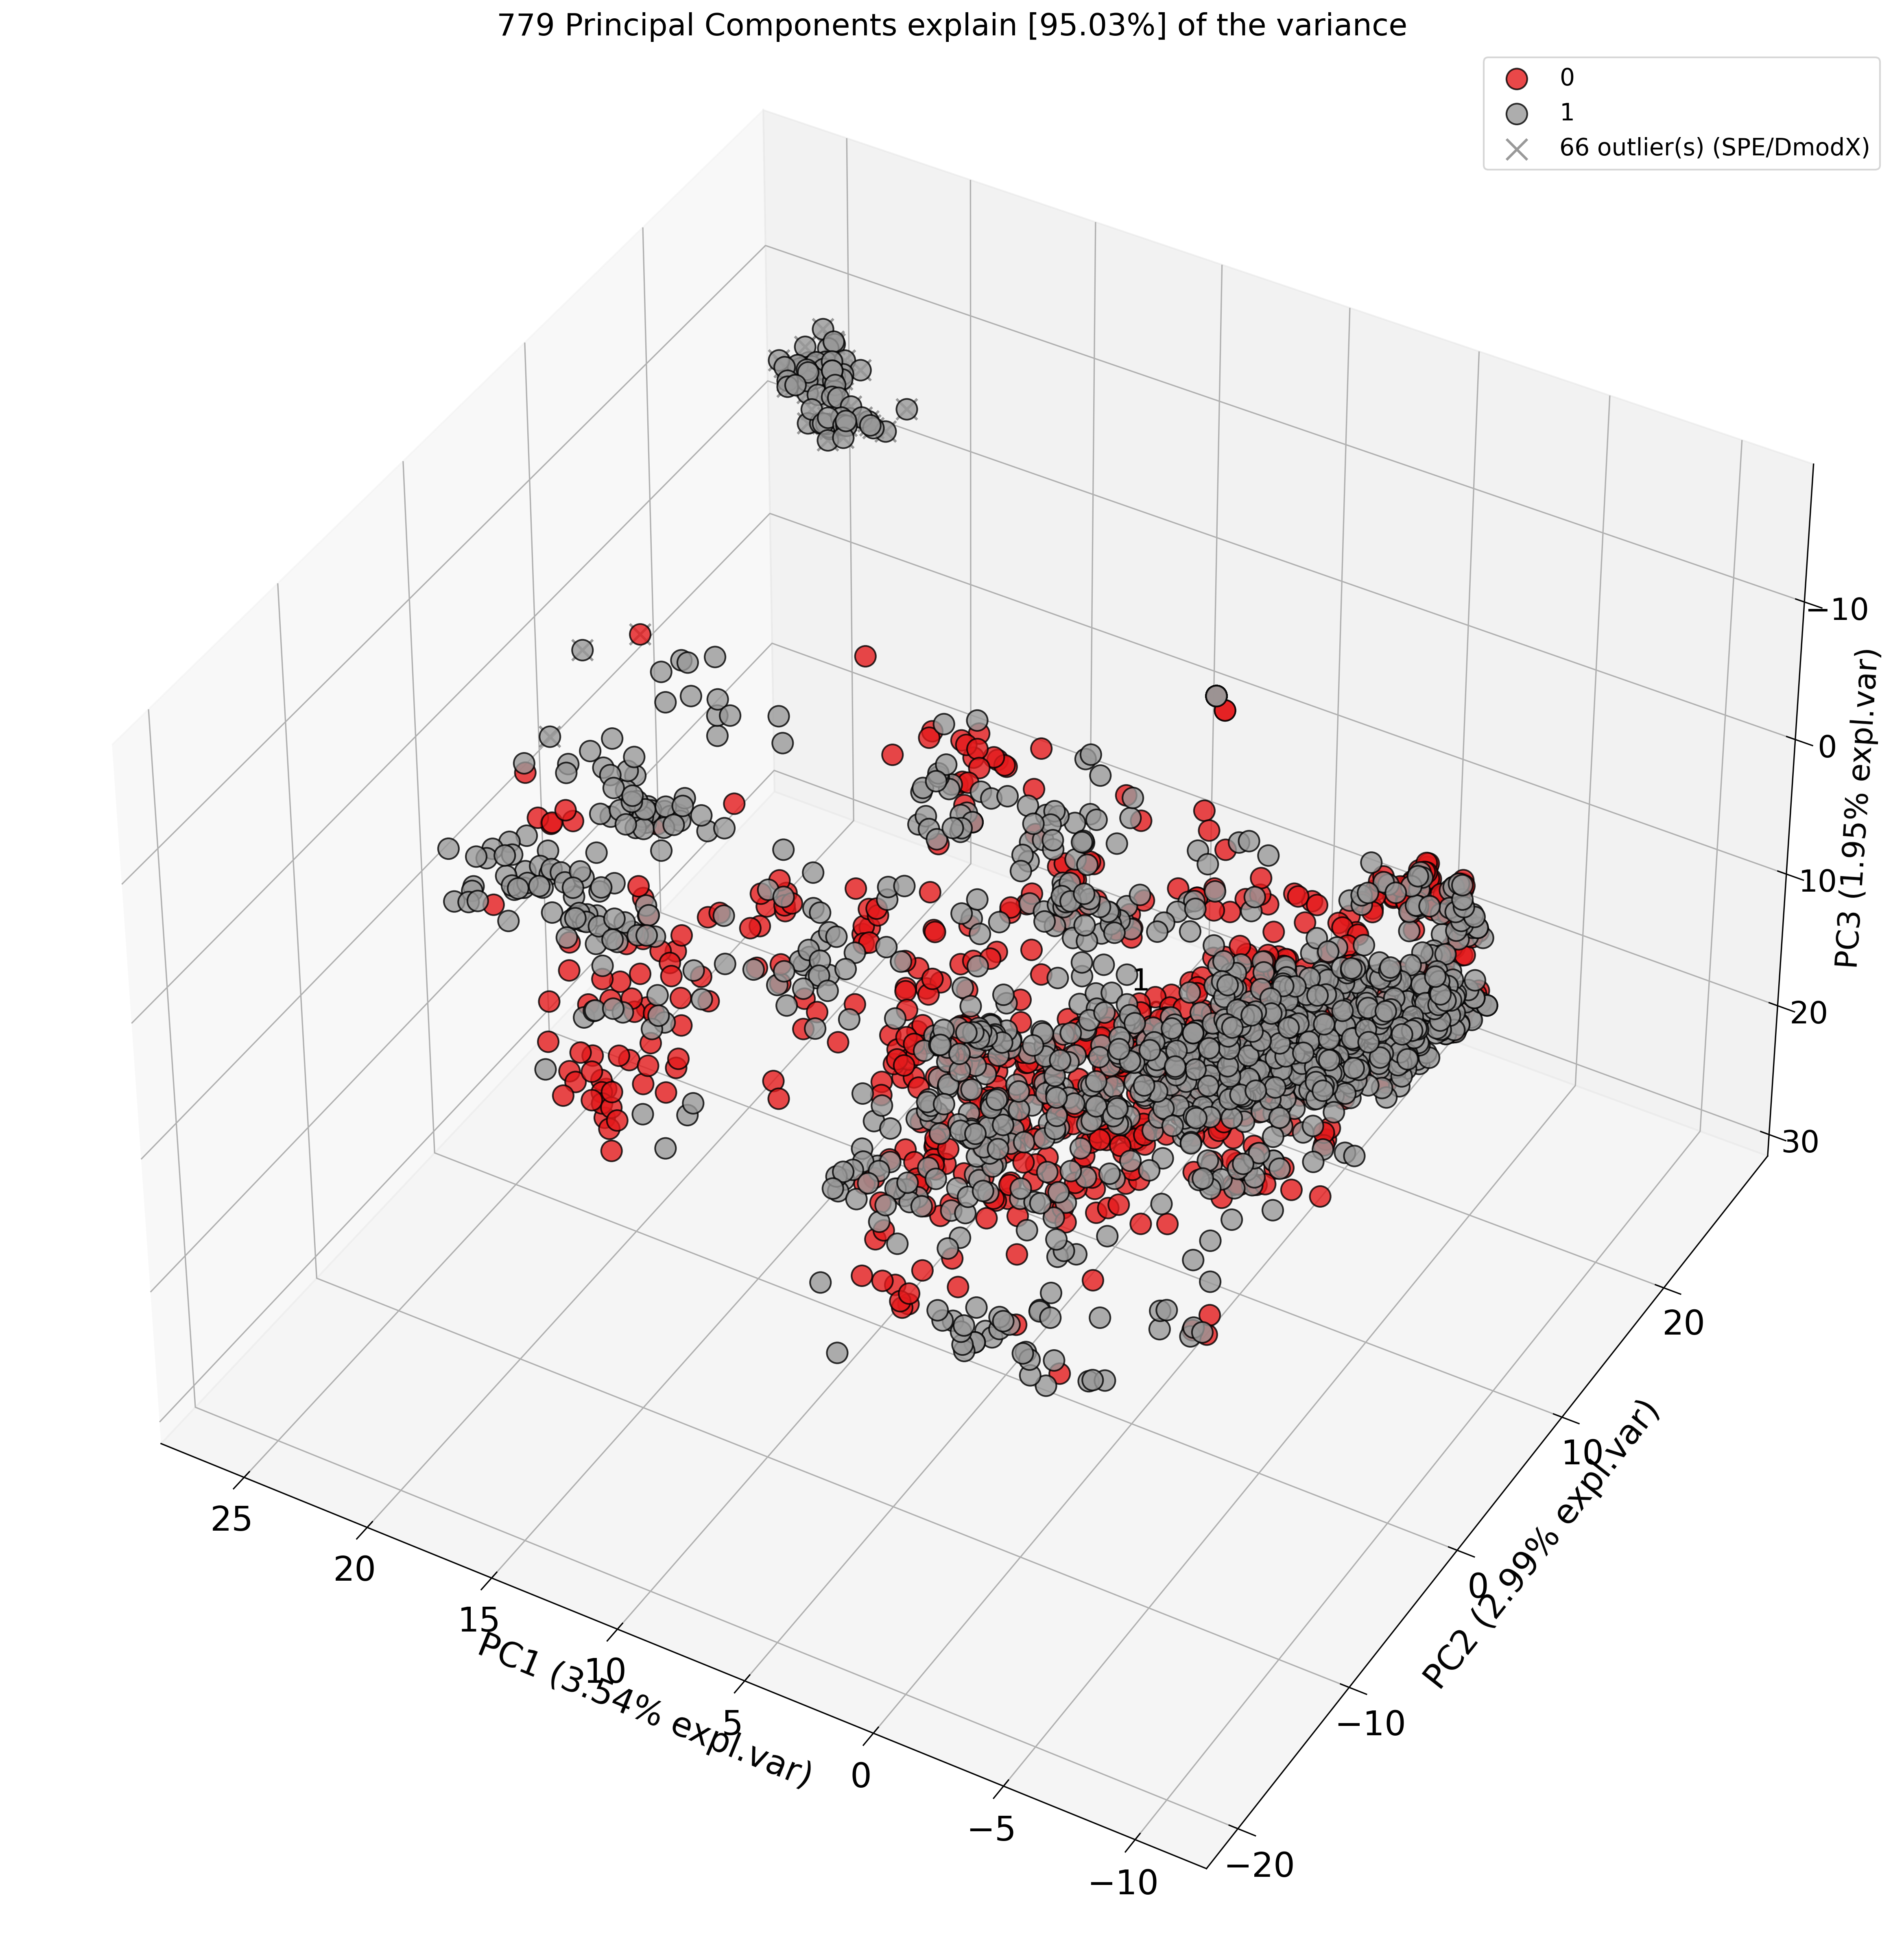

In [9]:
# 3D plot
model.scatter3d(labels=y, SPE=True, legend=True, cmap='Set1', figsize=(30,20), dpi=300);

#**Preprocessing**

In [10]:
# Print outliers
pd.set_option('display.max_rows', model.results['outliers'].shape[0]+1)
spe = model.results['outliers']
outlier = spe.loc[spe['y_bool_spe']==True]
outlier

<IPython.core.display.Javascript object>

y_proba          p_raw      y_score  y_bool  y_bool_spe  \
178   5.715934e-284  7.560759e-285  4514.028841    True        True   
764    0.000000e+00   0.000000e+00  5867.585830    True        True   
1220   0.000000e+00   0.000000e+00  4889.675574    True        True   
1221   0.000000e+00   0.000000e+00  4988.593119    True        True   
1222   0.000000e+00   0.000000e+00  5084.901126    True        True   
1223   0.000000e+00   0.000000e+00  5030.319113    True        True   
1224   0.000000e+00   0.000000e+00  5065.912705    True        True   
1225   0.000000e+00   0.000000e+00  4716.158405    True        True   
1226   0.000000e+00   0.000000e+00  4966.808225    True        True   
1227   0.000000e+00   0.000000e+00  5087.785894    True        True   
1228   0.000000e+00   0.000000e+00  5016.611933    True        True   
1229   0.000000e+00   0.000000e+00  4919.669714    True        True   
1230   0.000000e+00   0.000000e+00  4963.648070    True        True   
1231   0.000000e+00   0.000000e+00  5069.968703    True        True   
1232   0.000000e+00   0.000000e+00  4958.741536    True        True   
1233   0.000000e+00   0.000000e+00  4735.322968    True        True   
1234   0.000000e+00   0.000000e+00  4777.145329    True        True   
1235   0.000000e+00   0.000000e+00  4782.118549    True        True   
1236   0.000000e+00   0.000000e+00  4919.426074    True        True   
1237   0.000000e+00   0.000000e+00  5133.433611    True        True   
1238   0.000000e+00   0.000000e+00  5067.220223    True        True   
1239   0.000000e+00   0.000000e+00  5178.197089    True        True   
1240   0.000000e+00   0.000000e+00  5179.405143    True        True   
1241   0.000000e+00   0.000000e+00  5261.827705    True        True   
1242   0.000000e+00   0.000000e+00  4808.756565    True        True   
1243   0.000000e+00   0.000000e+00  4799.232816    True        True   
1244   0.000000e+00   0.000000e+00  4813.072277    True        True   
1245   0.000000e+00   0.000000e+00  4788.609817    True        True   
1246  2.852984e-302  3.685733e-303  4641.742146    True        True   
1247   0.000000e+00   0.000000e+00  4936.893468    True        True   
1248   0.000000e+00   0.000000e+00  4758.005981    True        True   
1249  1.213473e-298  1.583721e-299  4616.547685    True        True   
1250   0.000000e+00   0.000000e+00  4733.113567    True        True   
1251   0.000000e+00   0.000000e+00  4775.296445    True        True   
1252   0.000000e+00   0.000000e+00  4766.290086    True        True   
1253   0.000000e+00   0.000000e+00  5021.683931    True        True   
1254   0.000000e+00   0.000000e+00  4814.938299    True        True   
1255   0.000000e+00   0.000000e+00  4768.133657    True        True   
1256   0.000000e+00   0.000000e+00  4936.037416    True        True   
1257   0.000000e+00   0.000000e+00  4846.550291    True        True   
1258   0.000000e+00   0.000000e+00  4896.117793    True        True   
1259   0.000000e+00   0.000000e+00  4864.792163    True        True   
1260   0.000000e+00   0.000000e+00  4886.291249    True        True   
1261   0.000000e+00   0.000000e+00  5017.715090    True        True   
1262   0.000000e+00   0.000000e+00  4857.139662    True        True   
1263   0.000000e+00   0.000000e+00  4935.044348    True        True   
1264   0.000000e+00   0.000000e+00  4893.221899    True        True   
1265   0.000000e+00   0.000000e+00  4824.061380    True        True   
1266   0.000000e+00   0.000000e+00  4874.748392    True        True   
1267  3.976024e-190  6.328680e-191  3823.271926    True        True   
1268   0.000000e+00   0.000000e+00  4874.725659    True        True   
1269   0.000000e+00   0.000000e+00  4928.913436    True        True   
1270   0.000000e+00   0.000000e+00  4951.885424    True        True   
1271   0.000000e+00   0.000000e+00  4950.561954    True        True   
1272   0.000000e+00   0.000000e+00  4916.724089    True        True   
1273  4.438740e-194  7.026048e-195  

In [11]:
# Print values to remove
remove = outlier.index.values
remove

array([ 178,  764, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228,
       1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239,
       1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250,
       1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1298, 1688])

In [12]:
data1 = data.drop(data.index[[ 178,  764, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228,
       1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239,
       1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250,
       1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1298, 1688]])

X1 = data1.loc[:, ~data1.columns.isin(['id', 'smiles', 'Ecoli'])]
y1 = data1.iloc[:, 2].values
print(X1.shape)
X1.head()

(2202, 2048)


ECFP0  ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  ...  \
0      0      1      0      0      0      1      0      0      1      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      1      0      0      0      0      0      0      1      0  ...   
3      0      1      0      0      0      0      0      0      0      0  ...   
4      0      1      0      0      0      0      0      0      0      0  ...   

   ECFP2038  ECFP2039  ECFP2040  ECFP2041  ECFP2042  ECFP2043  ECFP2044  \
0         0         0         0         0         0         0         0   
1         0         0         0         1         1         0         0   
2         0         0         0         0         0         0         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         1         0         0   

   ECFP2045  ECFP2046  ECFP2047  
0         0         0         0  
1         0         0         0  
2         1         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 2048 columns]

In [13]:
# Split dataset into train & test set
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, stratify=y1,
                                                   random_state=42)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 1761   size of test set: 441



#**Logit**

In [14]:
# Perform random search to optimize parameters for logit
logit = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
param = {'C': np.logspace(-3,3,30)}
logit_cv = RandomizedSearchCV(logit, param, cv=10, n_jobs=-1, random_state=42)
logit_cv.fit(X_train, y_train)

print('best paremeters: ', logit_cv.best_params_)
print('best score after random search cv:', logit_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'C': 0.0727895384398315}
best score after random search cv: 0.7921578068823832


In [15]:
# Zoom on specific values
logit = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
param = {'C': np.linspace(4.5203e-2,1.1721e-1,30)}
logit_cv = RandomizedSearchCV(logit, param, cv=10, n_jobs=-1, random_state=42)
logit_cv.fit(X_train, y_train)

print('best paremeters: ', logit_cv.best_params_)
print('best score after random search cv:', logit_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'C': 0.104795}
best score after random search cv: 0.7967000513610684


In [16]:
# Train logit
logit_tuned = LogisticRegression(max_iter=5000, class_weight='balanced',
                                 C=0.10480, n_jobs=-1, random_state=42)
logit_tuned.fit(X_train, y_train)

# Print intercept & coefficients
print('intercept:', logit_tuned.intercept_)
print('coef:', logit_tuned.coef_, end='\n')

<IPython.core.display.Javascript object>

intercept: [-2.45921578]
coef: [[ 0.07675418 -0.02980029  0.12261091 ...  0.03202784  0.24237511
   0.04485367]]


In [17]:
# Evaluate the logit model on training set
print("Performance of logit model on training set")
y_train_pred = cross_val_predict(logit_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of logit model on training set
accuracy: 0.7967
precision: 0.8247
sensitivity: 0.8295
F1: 0.8271
MCC: 0.5805
AUROC: 0.7899


#**KNN**

In [18]:
# Perform random search to optimize parameters for KNN
knn = KNeighborsClassifier()
param = {'n_neighbors': range(3,20), 'weights': ['uniform', 'distance'],
         'leaf_size': range(10,50), 'p': [1,2,3]}
knn_cv = RandomizedSearchCV(knn, param, cv=10, n_jobs=-1, random_state=42)
knn_cv.fit(X_train, y_train)

print('best paremeters: ', knn_cv.best_params_)
print('best score after random search cv:', knn_cv.best_score_)

<IPython.core.display.Javascript object>

best paremeters:  {'weights': 'distance', 'p': 2, 'n_neighbors': 7, 'leaf_size': 31}
best score after random search cv: 0.763755136106831


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

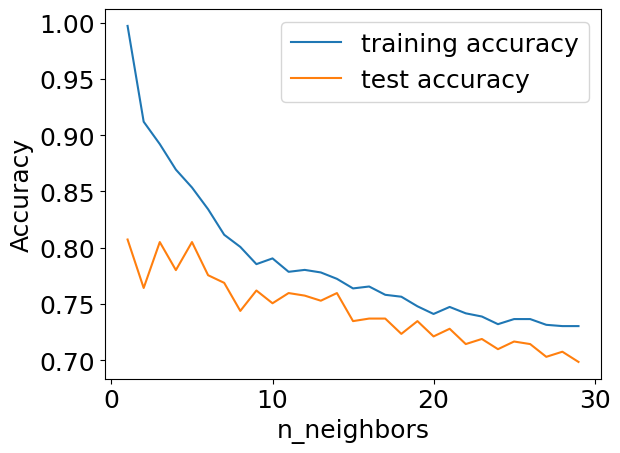

In [19]:
# Find the optimum k
train_acc = []
test_acc = []
# try n_neighbors from 1 to 30
neighbors_settings = range(1, 30)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    train_acc.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_acc.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, train_acc, label="training accuracy")
plt.plot(neighbors_settings, test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [20]:
# Train KNN
knn_tuned = KNeighborsClassifier(n_neighbors=7, weights='distance', leaf_size=31,
                                 p=2, n_jobs=-1)
knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=31, n_jobs=-1, n_neighbors=7, weights='distance')

In [21]:
# Evaluate the KNN model on training set
print("Performance of KNN model on training set")
y_train_pred = cross_val_predict(knn_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of KNN model on training set
accuracy: 0.7638
precision: 0.7726
sensitivity: 0.8459
F1: 0.8076
MCC: 0.5068
AUROC: 0.7467


#**SVC**

In [22]:
# Perform random search to optimize parameters for SVC
svc = SVC(class_weight='balanced', random_state=42)
param = {'C': np.linspace(0.01,10,20), 'kernel': ['rbf'], 'gamma': np.logspace(-6,1,20)}
svc_cv = RandomizedSearchCV(svc, param, cv=10, n_jobs=-1, random_state=42)
svc_cv.fit(X_train, y_train)

print('best paremeters: ', svc_cv.best_params_)
print('best score after random search cv:', svc_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'kernel': 'rbf', 'gamma': 0.004832930238571752, 'C': 5.267894736842106}
best score after random search cv: 0.8205476373908578


In [23]:
# Zoom on specific values
svc = SVC(class_weight='balanced', random_state=42)
param = {'C': np.linspace(4.7421,5.7937,20), 'kernel': ['rbf'], 'gamma': np.linspace(2.0691e-3,1.1288e-2,20)}
svc_cv = RandomizedSearchCV(svc, param, cv=10, n_jobs=-1, random_state=42)
svc_cv.fit(X_train, y_train)

print('best paremeters: ', svc_cv.best_params_)
print('best score after random search cv:', svc_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'kernel': 'rbf', 'gamma': 0.0049803315789473685, 'C': 5.074184210526315}
best score after random search cv: 0.8216872110939908


In [24]:
# Train SVC
svc_tuned = SVC(C=5.0742, kernel='rbf', gamma=4.9803e-3, class_weight='balanced',
                probability=True, random_state=42)
svc_tuned.fit(X_train, y_train)

SVC(C=5.0742, class_weight='balanced', gamma=0.0049803, probability=True,
    random_state=42)

In [25]:
# Evaluate the SVC model on training set
print("Performance of SVC model on training set")
y_train_pred = cross_val_predict(svc_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of SVC model on training set
accuracy: 0.8217
precision: 0.8306
sensitivity: 0.8740
F1: 0.8517
MCC: 0.6298
AUROC: 0.8108


#**RF**

In [26]:
# Perform random search to optimize parameters for RF
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
param = {'n_estimators': np.linspace(100,1200,20).astype(int),
         'criterion': ['gini', 'entropy'],
         'max_depth': np.linspace(5,40,20).astype(int),
         'max_features':['sqrt', 'log2', None]}
forest_cv = RandomizedSearchCV(forest, param, n_jobs=-1, cv=10, random_state=42)
forest_cv.fit(X_train, y_train)

print('best paremeters: ', forest_cv.best_params_)
print('best score after random search cv:', forest_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'n_estimators': 621, 'max_features': 'sqrt', 'max_depth': 34, 'criterion': 'entropy'}
best score after random search cv: 0.809180790960452


In [27]:
# Zoom on specific values
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
param = {'n_estimators': range(563,679),
         'criterion': ['entropy'],
         'max_depth': range(30,40),
         'max_features':['sqrt']}
forest_cv = RandomizedSearchCV(forest, param, n_jobs=-1, cv=10, random_state=42)
forest_cv.fit(X_train, y_train)

print('best paremeters: ', forest_cv.best_params_)
print('best score after random search cv:', forest_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'n_estimators': 661, 'max_features': 'sqrt', 'max_depth': 32, 'criterion': 'entropy'}
best score after random search cv: 0.8086126091422703


In [28]:
# Train RF
forest_tuned = RandomForestClassifier(n_estimators=661, criterion='entropy', max_depth=32,
                                      max_features='sqrt', class_weight='balanced',
                                      n_jobs=-1, random_state=42)
forest_tuned.fit(X_train, y_train)

<IPython.core.display.Javascript object>

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=32, n_estimators=661, n_jobs=-1,
                       random_state=42)

In [29]:
# Evaluate the RF model on training set
print("Performance of RF model on training set")
y_train_pred = cross_val_predict(forest_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of RF model on training set
accuracy: 0.8086
precision: 0.7988
sensitivity: 0.9002
F1: 0.8465
MCC: 0.6024
AUROC: 0.7896


#**XGB**

In [31]:
# Perform random search to optimize parameters for XGB
xgb = XGBClassifier(tree_method='hist', device='cuda', objective='binary:logistic',
                    scale_pos_weight=1, random_state=42)
param = {'learning_rate': np.logspace(-3,0,20),
         'n_estimators': np.linspace(100,1200,20).astype(int),
         'gamma': np.logspace(-6,1,20),
         'max_depth': np.linspace(5,30,20).astype(int),
         'subsample': np.linspace(0,1,20),
         'colsample_bytree': np.linspace(0,1,20),
         'alpha': np.logspace(-3,3,20)}
xgb_cv = RandomizedSearchCV(xgb, param, cv=10, random_state=42)
xgb_cv.fit(X_train, y_train)

print('best paremeters: ', xgb_cv.best_params_)
print('best score after random search cv:', xgb_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'subsample': 0.7368421052631579, 'n_estimators': 678, 'max_depth': 20, 'learning_rate': 0.11288378916846883, 'gamma': 1.274274985703132e-05, 'colsample_bytree': 0.7368421052631579, 'alpha': 0.07847599703514611}
best score after random search cv: 0.8233724961479199


In [32]:
# Zoom on specific values
xgb = XGBClassifier(tree_method='hist', device='cuda', objective='binary:logistic',
                    scale_pos_weight=1, random_state=42)
param = {'learning_rate': np.linspace(7.8476e-2,1.6238e-1,20),
         'n_estimators': range(621,737),
         'gamma': np.linspace(5.4556e-6,2.9764e-5,20),
         'max_depth': range(15,25),
         'subsample': np.linspace(0.68421,0.78947,20),
         'colsample_bytree': np.linspace(0.68421,0.78947,20),
         'alpha': np.linspace(3.7927e-2,1.6234e-1,20)}
xgb_cv = RandomizedSearchCV(xgb, param, cv=10, random_state=42)
xgb_cv.fit(X_train, y_train)

print('best paremeters: ', xgb_cv.best_params_)
print('best score after random search cv:', xgb_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'subsample': 0.7673099999999999, 'n_estimators': 687, 'max_depth': 20, 'learning_rate': 0.087308, 'gamma': 2.720522105263158e-05, 'colsample_bytree': 0.68421, 'alpha': 0.15579194736842106}
best score after random search cv: 0.8171353364149976


In [33]:
# Train XGB
xgb_tuned = XGBClassifier(tree_method='hist', device='cuda', objective='binary:logistic',
                          scale_pos_weight=1, learning_rate=0.11288, n_estimators=678,
                          gamma=1.2743e-5, max_depth=20, subsample=0.73684,
                          colsample_bytree=0.73684, alpha=7.8476e-2, random_state=42)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(alpha=0.078476, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.73684, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2743e-05,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11288, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=678, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
# Evaluate the XGB model on training set
print("Performance of XGB model on training set")
y_train_pred = cross_val_predict(xgb_tuned, X_train, y_train, cv=10)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of XGB model on training set
accuracy: 0.8194
precision: 0.8240
sensitivity: 0.8798
F1: 0.8510
MCC: 0.6247
AUROC: 0.8069


#**LGBM**

In [37]:
# Perform random search to optimize parameters for LGBM
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True, bagging_freq=1,
                      verbose=-1, random_state=42)
param = {'n_estimators': np.linspace(100,1200,20).astype(int),
         'learning_rate': np.logspace(-3,0,20),
         'num_leaves': np.linspace(10,300,20).astype(int),
         'max_depth': range(5,30),
         'min_data_in_leaf': np.linspace(20,300,20).astype(int),
         'bagging_fraction': np.linspace(0.5,0.9,5),
         'feature_fraction': np.linspace(0.5,0.9,5)}
lgbm_cv = RandomizedSearchCV(lgbm, param, cv=10, random_state=42)
lgbm_cv.fit(X_train, y_train)

print('best paremeters: ', lgbm_cv.best_params_)
print('best score after random search cv:', lgbm_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'num_leaves': 193, 'n_estimators': 910, 'min_data_in_leaf': 93, 'max_depth': 16, 'learning_rate': 0.23357214690901212, 'feature_fraction': 0.7, 'bagging_fraction': 0.9}
best score after random search cv: 0.8165575243965074


In [38]:
# Zoom on specific values
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True, bagging_freq=1,
                     verbose=-1, random_state=42)
param = {'n_estimators': range(853,968),
         'learning_rate': np.linspace(0.16238,0.33598,20),
         'num_leaves': range(178,208),
         'max_depth': range(10,20),
         'min_data_in_leaf': range(79,108),
         'bagging_fraction': np.linspace(0.5,0.9,5),
         'feature_fraction': np.linspace(0.5,0.9,5)}
lgbm_cv = RandomizedSearchCV(lgbm, param, cv=10, random_state=42)
lgbm_cv.fit(X_train, y_train)

print('best paremeters: ', lgbm_cv.best_params_)
print('best score after random search cv:', lgbm_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'num_leaves': 195, 'n_estimators': 965, 'min_data_in_leaf': 99, 'max_depth': 10, 'learning_rate': 0.19892736842105263, 'feature_fraction': 0.5, 'bagging_fraction': 0.8}
best score after random search cv: 0.8142847971237803


In [39]:
# Train LGBM
lgbm_tuned = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True,
                            n_estimators=910, learning_rate=0.23357, num_leaves=193,
                            max_depth=16, min_data_in_leaf=93, bagging_fraction=0.9,
                            bagging_freq=1, feature_fraction=0.7, verbose=-1, random_state=42)
lgbm_tuned.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, device='cpu',
               feature_fraction=0.7, is_unbalance=True, learning_rate=0.23357,
               max_depth=16, min_data_in_leaf=93, n_estimators=910,
               num_leaves=193, objective='binary', random_state=42, verbose=-1)

In [40]:
# Evaluate the LGBM model on training set
print("Performance of LGBM model on training set")
y_train_pred = cross_val_predict(lgbm_tuned, X_train, y_train, cv=10)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of LGBM model on training set
accuracy: 0.8160
precision: 0.8308
sensitivity: 0.8614
F1: 0.8459
MCC: 0.6185
AUROC: 0.8066


#**Vote**

In [41]:
# Train voting model
vote = VotingClassifier(estimators=[('svc', svc_tuned), ('xgb', xgb_tuned),
                                     ('lgbm', lgbm_tuned)], voting='soft')

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              SVC(C=5.0742, class_weight='balanced',
                                  gamma=0.0049803, probability=True,
                                  random_state=42)),
                             ('xgb',
                              XGBClassifier(alpha=0.078476, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.73684,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metri...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=678, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=1, device='cpu',
                                             feature_fraction=0.7,
                                             is_unbalance=True,
                                             learning_rate=0.23357,
                                             max_depth=16, min_data_in_leaf=93,
                                             n_estimators=910, num_leaves=193,
                                             objective='binary',
                                             random_state=42, verbose=-1))],
                 voting='soft')

In [42]:
# Evaluate the voting model on training set
print("Performance of vote model on training set")
y_train_pred = cross_val_predict(vote, X_train, y_train, cv=10)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of vote model on training set
accuracy: 0.8234
precision: 0.8310
sensitivity: 0.8769
F1: 0.8534
MCC: 0.6332
AUROC: 0.8123


#**Stack**

In [43]:
# Train stacking model
stack = StackingClassifier(estimators=[('svc', svc_tuned), ('rf', forest_tuned)])

stack.fit(X_train, y_train)

StackingClassifier(estimators=[('svc',
                                SVC(C=5.0742, class_weight='balanced',
                                    gamma=0.0049803, probability=True,
                                    random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=32,
                                                       n_estimators=661,
                                                       n_jobs=-1,
                                                       random_state=42))])

In [44]:
# Evaluate the stacking model on training set
print("Performance of stack model on training set")
y_train_pred = cross_val_predict(stack, X_train, y_train, cv=10)
print("accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("precision: {:.4f}".format(precision_score(y_train, y_train_pred)))
print("sensitivity: {:.4f}".format(recall_score(y_train, y_train_pred)))
print("F1: {:.4f}".format(f1_score(y_train, y_train_pred)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("AUROC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))

Performance of stack model on training set
accuracy: 0.8223
precision: 0.8289
sensitivity: 0.8779
F1: 0.8527
MCC: 0.6308
AUROC: 0.8107


#**PR curves**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

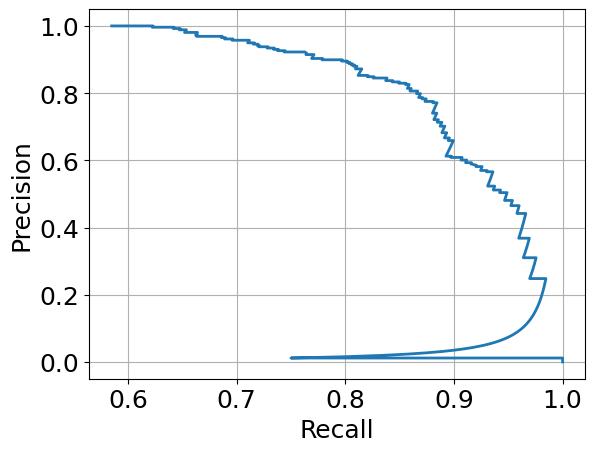

In [45]:
# Plot PR curve for logit model
y_thres = logit_tuned.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_thres)
def plot_PR_curve(precision, recall, label=None):
    plt.plot(precision, recall, linewidth=2, label=label)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid()
plot_PR_curve(precision, recall)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

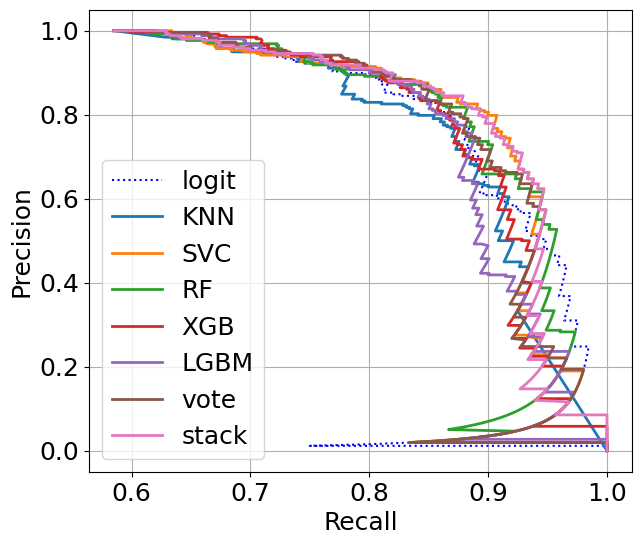

In [46]:
# Compare ROC curve for all models
y_proba_knn = knn_tuned.predict_proba(X_test)[:, 1]
y_thres_svc = svc_tuned.decision_function(X_test)
y_proba_forest = forest_tuned.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
y_proba_lgbm = lgbm_tuned.predict_proba(X_test)[:, 1]
y_proba_vote = vote.predict_proba(X_test)[:, 1]
y_proba_stack = stack.predict_proba(X_test)[:, 1]

precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, y_proba_knn)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test, y_thres_svc)
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_test, y_proba_forest)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test, y_proba_lgbm)
precision_vote, recall_vote, thresholds_vote = precision_recall_curve(y_test, y_proba_vote)
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_proba_stack)

plt.figure(figsize=(7, 6))
plt.plot(precision, recall, "b:", label="logit")
plot_PR_curve(precision_knn, recall_knn, "KNN")
plot_PR_curve(precision_svc, recall_svc, "SVC")
plot_PR_curve(precision_forest, recall_forest, "RF")
plot_PR_curve(precision_xgb, recall_xgb, "XGB")
plot_PR_curve(precision_lgbm, recall_lgbm, "LGBM")
plot_PR_curve(precision_vote, recall_vote, "vote")
plot_PR_curve(precision_stack, recall_stack, "stack")

plt.legend(loc="best")

#**ROC curves**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

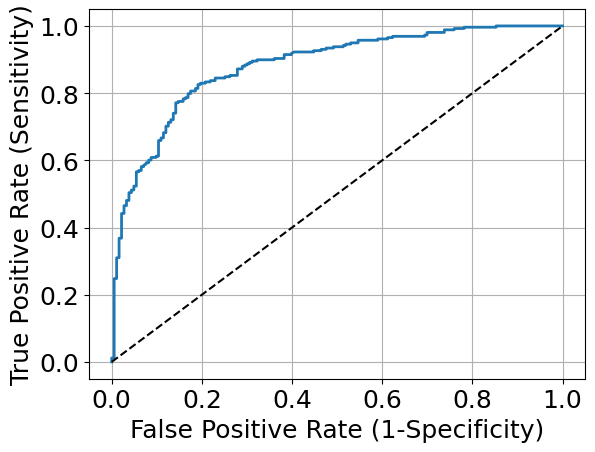

In [47]:
# Plot ROC curve for logit model
fpr, tpr, thresholds = roc_curve(y_test, y_thres)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.grid()
plot_roc_curve(fpr, tpr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

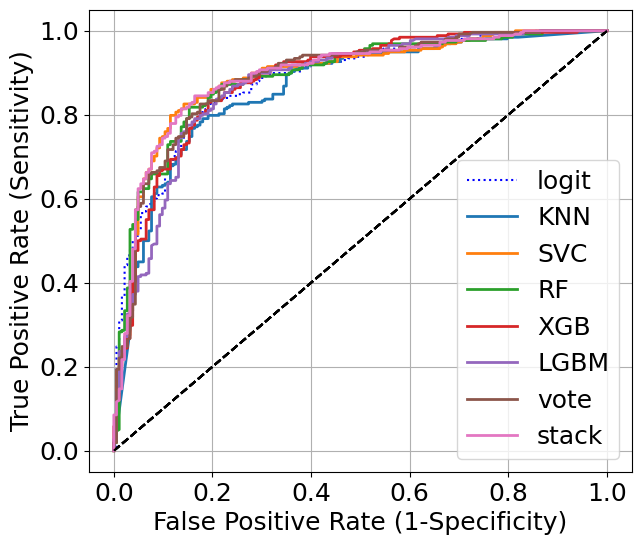

In [48]:
# Compare ROC curve for all models
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_thres_svc)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_proba_forest)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_proba_lgbm)
fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_proba_vote)
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_proba_stack)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, "b:", label="logit")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plot_roc_curve(fpr_forest, tpr_forest, "RF")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGB")
plot_roc_curve(fpr_lgbm, tpr_lgbm, "LGBM")
plot_roc_curve(fpr_vote, tpr_vote, "vote")
plot_roc_curve(fpr_stack, tpr_stack, "stack")

plt.legend(loc="lower right")

#**Evaluation**

In [49]:
# Evaluate the voting model on test set
y_pred_vote = vote.predict(X_test)
y_proba_vote = vote.predict_proba(X_test)[:, 1]
print("Performance of vote model on test set")
print("accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_vote)))
print("precision: {:.4f}".format(precision_score(y_test, y_pred_vote)))
print("sensitivity: {:.4f}".format(recall_score(y_test, y_pred_vote)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_vote)))
print("MCC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_vote)))
print("AUROC: {:.4f}".format(roc_auc_score(y_test, y_proba_vote)))


Performance of vote model on test set
accuracy: 0.8231
precision: 0.8488
sensitivity: 0.8488
F1: 0.8488
MCC: 0.6357
AUROC: 0.8896


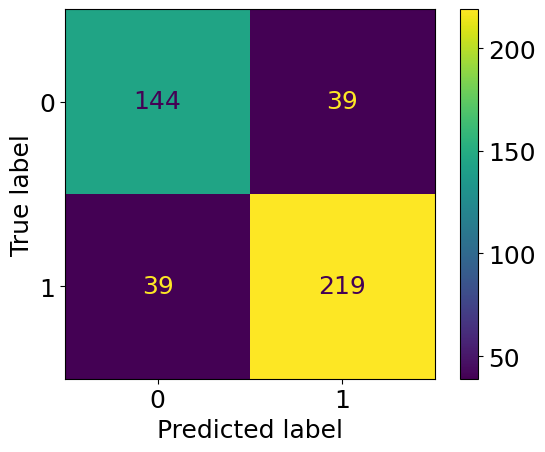

In [50]:
# Plot confusion matrix for the voting model
cm = confusion_matrix(y_test, y_pred_vote, labels=vote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vote.classes_)
disp.plot()

In [51]:
# Output observations that were incorrectly labeled
Flabel = pd.DataFrame(X_test[y_test != y_pred_vote])
Flabel

<IPython.core.display.Javascript object>

ECFP0  ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  \
5         0      1      0      0      0      0      0      0      0      0   
1738      0      1      0      0      0      0      0      0      0      0   
1949      0      1      0      0      1      0      0      0      1      0   
558       0      1      0      0      0      1      0      1      0      0   
43        0      1      0      0      0      0      0      0      1      0   
551       0      1      0      0      0      0      0      0      1      0   
2223      0      1      0      0      0      0      0      0      0      0   
1092      0      1      0      0      0      0      0      0      0      0   
681       0      1      0      0      0      0      0      0      0      0   
1135      0      1      0      0      0      0      0      0      0      0   
134       0      1      0      0      0      0      0      0      1      0   
1727      0      1      0      0      0      0      0      0      0      0   
1420      0      1      0      0      0      0      0      0      0      0   
1360      0      1      0      0      0      0      0      0      0      0   
1181      0      1      1      0      0      0      0      0      1      0   
272       0      1      0      0      0      0      0      1      0      0   
74        0      1      0      0      0      1      0      0      1      0   
253       0      1      0      0      1      0      0      0      0      0   
54        0      1      0      0      0      0      0      0      0      0   
844       0      1      0      0      0      0      0      0      1      0   
257       0      1      0      0      0      0      0      0      0      0   
665       1      1      0      0      0      0      0      0      0      0   
154       0      1      0      0      0      0      1      0      0      0   
80        0      1      0      1      0      0      0      0      0      0   
962       0      1      0      0      0      0      0      0      0      0   
1150      0      1      0      0      0      1      0      0      0      0   
2074      0      1      0      0      0      0      0      0      0      0   
1355      0      1      0      0      1      1      0      0      0      0   
2035      0      1      0      0      0      0      0      0      0      0   
1782      0      1      0      0      0      0      0      0      1      0   
1419      0      1      0      0      0      0      0      0      0      0   
1418      1      1      0      1      0      0      0      0      1      1   
1778      0      1      0      0      0      0      0      0      1      0   
605       0      1      0      0      0      0      0      0      0      0   
417       1      1      0      0      0      0      0      0      0      0   
172       0      1      0      0      0      0      0      0      0      0   
2195      0      1      0      0      0      0      0      0      1      0   
476       0      1      1      0      0      0      0      0      1      0   
1178      0      1      0      0      0      1      0      0      1      0   
2064      0      1      0      0      0      0      0      0      0      0   
499       0      1      0      0      0      0      0      1      0      0   
811       0      1      0      0      0      0      0      0      0      0   
781       0      1      0      0      0      0      0      0      0      0   
225       0      1      0      0      1      0      0      0      1      0   
359       0      1      0      0      1      0      0      0      1      0   
2182      0      1      1      0      0      0      0      0      0      0   
641       0      1      0      1      0      0      0      0      1      0   
1980      0      1      0      0      0      0      0      0      0      0   
1376      0      1      0      0      0      0      0      0      1      0   
1455      1      1      0      0      1      0      0      0      0      1   
155       0      1      0   